<a href="https://colab.research.google.com/github/HananeMaghlazi/P7_Scoring/blob/main/P7_Modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time
import fnmatch

# Pour les warnings
import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.WARNING)  # disable WARNING, INFO and DEBUG logging everywhere
# Pour le ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pandas import MultiIndex, Int16Dtype
from pandas import MultiIndex, Int64Index
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/gdrive


In [4]:
link = 'https://drive.google.com/file/d/1kLKanGI2qrJPCWd5OUgSku9R6AukXocf/view?usp=share_link'
 

 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('xclara.csv') 
 
data = pd.read_csv('xclara.csv')

In [5]:
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [6]:
data.shape

(307507, 790)

In [7]:
# J'extrais un échantillon 1 % :
data_sample = data.sample(frac=0.01).round(3)
data_sample.shape

(3075, 790)

In [8]:
data_sample.TARGET.value_counts(normalize="True")

0.0    0.918049
1.0    0.081951
Name: TARGET, dtype: float64

In [9]:
data_sample.TARGET.value_counts()

0.0    2823
1.0     252
Name: TARGET, dtype: int64

In [10]:
# Les features
X = data_sample.drop(["TARGET", "SK_ID_CURR"], axis=1)
# La target
Y = data_sample[["TARGET"]]
# Division du dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, stratify=Y, random_state=42
)
print("shape of original dataset :", data_sample.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (3075, 790)
shape of input - training set (2460, 788)
shape of output - training set (2460, 1)
shape of input - testing set (615, 788)
shape of output - testing set (615, 1)


In [11]:
print("Classe 1, sans SMOTE ", (y_train == 1).sum())
print("Classe 0, sans SMOTE:", (y_train == 0).sum())

Classe 1, sans SMOTE  TARGET    202
dtype: int64
Classe 0, sans SMOTE: TARGET    2258
dtype: int64


In [12]:
lr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42))
lr

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [13]:
# Fonction qui va entrainer le modèle,prédire et évaluer l'ensemble des modèles
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_true = y_test
    print(classification_report(y_true, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC : %0.4f" % roc_auc)

    fig = plt.figure(figsize=(20, 15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

    plt.subplot(222)

    fper, tper, thresholds = roc_curve(y_true, y_pred_proba)
    plt.plot(fper, tper, color="red", label="AUC = %0.4f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend()
    plt.show()

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       565
         1.0       0.08      0.02      0.03        50

    accuracy                           0.90       615
   macro avg       0.50      0.50      0.49       615
weighted avg       0.85      0.90      0.87       615

AUC : 0.6094


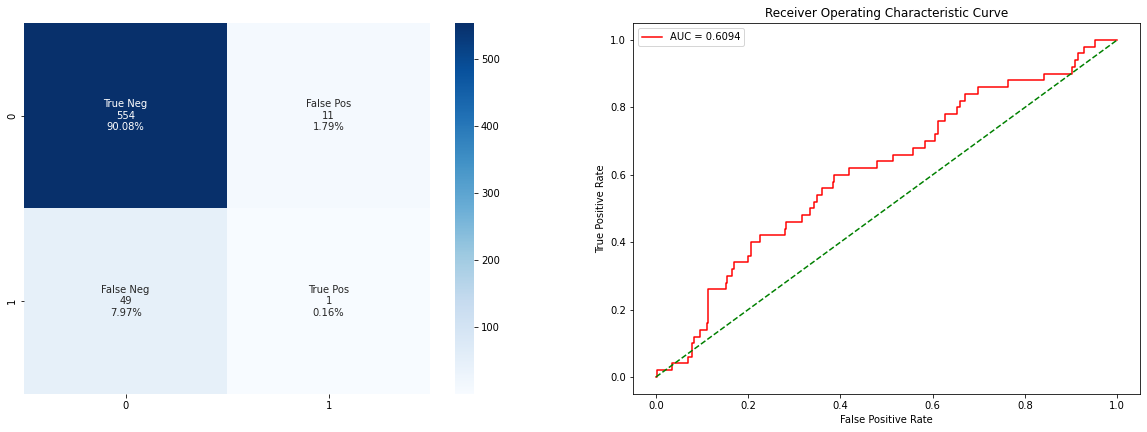

In [14]:
evaluation(lr)

XGBClassifier :

In [15]:
xgb = make_pipeline(MinMaxScaler(), XGBClassifier(random_state=42))
xgb

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier', XGBClassifier(random_state=42))])

GradientBoosting : 

In [16]:
grb = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))
grb

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

LGBMClassifier :

In [17]:
lgt = make_pipeline(MinMaxScaler(), LGBMClassifier(random_state=42))
lgt

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [18]:
model_pipeline = {
    
    "Gradientboosting": grb,
    "Xgbregressor": xgb,
    "LightGBM": lgt,
}

In [19]:
def metrics_models(model_pipeline):
    
    results = []
    cm_list = []
    for model_pipeline_name, model in model_pipeline.items():
        model.fit(X_train, y_train.values.ravel())
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy = accuracy_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        f1 = f1_score(y_test, model.predict(X_test))
        cm_list.append(confusion_matrix(y_test, model.predict(X_test)))

        results.append([model_pipeline_name, auc, accuracy, precision, recall, f1])
        df = pd.DataFrame(
            results, columns=["Models", "Auc", "Accuracy", "Precision", "Recall", "F1"]
        )
    return df, cm_list

In [20]:
df_results, cm_list = metrics_models(model_pipeline)

In [21]:
df_results

,Models,Auc,Accuracy,Precision,Recall,F1
0,Gradientboosting,0.621558,0.913821,0.2,0.02,0.036364
1,Xgbregressor,0.592920,0.920325,1.0,0.02,0.039216
2,LightGBM,0.611717,0.920325,1.0,0.02,0.039216


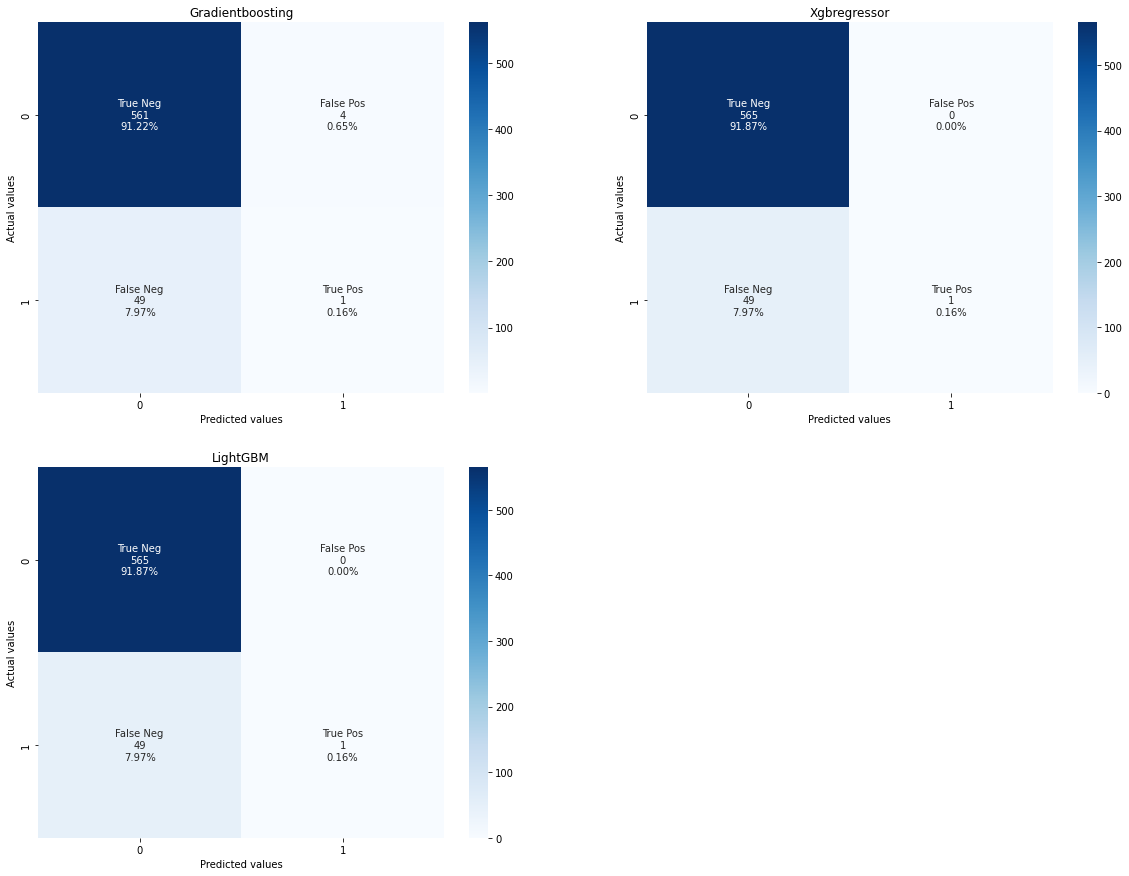

In [22]:
list_models = [
    
    
    "Gradientboosting",
    "Xgbregressor",
    "LightGBM",
]
# Visualisation des matrices de confusion
fig = plt.figure(figsize=(20, 15))

for i in range(len(cm_list)):
    model = list_models[i]
    cm = cm_list[i]
    sub = fig.add_subplot(2, 2, i + 1).set_title(model)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    cm_plot = sns.heatmap(cm, fmt="", annot=labels, cmap="Blues")
    cm_plot.set_xlabel("Predicted values")
    cm_plot.set_ylabel("Actual values")

In [23]:
# Utilisation du MinMaxScaler() pour normalisation des données dans la pipeline
preprocessor = make_pipeline(MinMaxScaler())
preprocessor

Pipeline(steps=[('minmaxscaler', MinMaxScaler())])

In [24]:
# transform the dataset
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
smt

SMOTE(random_state=42)